In [1]:
library(data.table)
library(geosphere)
source("../Old/util.R")
library(parallel)
library(ggplot2)
landing_ac_data <- ac_data <- readRDS("landing_subset.Rds")
print(nrow(ac_data))
setDT(ac_data)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


[1] 1342737


In [2]:
ground_speed_limit <- 3000 # knots
max_climb_rate <- 200 # ft/s
min_reqd_alt <- 10000 # ft
max_ground_speed_est_ratio <- 20
setorder(landing_ac_data, id, ts)

In [3]:
# ac_data$time_diff_condition <- (is.na(ac_data$next_ts) | ((ac_data$next_ts - ac_data$ts) > 1800))
# ac_data$alt_diff_condition <- ((ac_data$altitude - ac_data$last_altitude) < 0) |
#                                 ((ac_data$next_altitude - ac_data$altitude) < 0)


# ac_data$landing_condition <- data.table::between(x = ac_data$lon, lower = -75, upper = -72.5) &
#                       data.table::between(x = ac_data$lat, lower = 40, upper = 42) &
#                         ac_data$altitude <= 1500 & ac_data$alt_diff_condition &
#                         ac_data$time_diff_condition
# ac_data[, "landing" := cumsum(landing_condition), by=id]
# ac_data[, "land_max" := max(landing), by = id]
# landing_ac_data <- ac_data[ac_data$land_max != 0, ]

In [4]:
length(unique(landing_ac_data$id))

[1] 1853

In [5]:
# Keeping first row of lon, lat for each aircraft
setorder(landing_ac_data, id, ts)
landing_ac_data[, c("last_lon", "last_lat") := list(c(NA, lon[-.N]), c(NA, lat[-.N])), by = "id"]
landing_ac_data <- landing_ac_data[landing_ac_data$lon != landing_ac_data$last_lon | landing_ac_data$lat != landing_ac_data$last_lat, ]
print(nrow(ac_data))
landing_ac_data[, c("last_ts", "last_lon", "last_lat") := list(c(NA, ts[-.N]), c(NA, lon[-.N]), c(NA, lat[-.N])), by = "id"]

[1] 1342737


In [6]:
table(landing_ac_data$num_id)


     0      1      2      3      4      5      6      7 
741168 233101 178085  65161  44964  16063   3119    865 

In [7]:
nrow(landing_ac_data)
landing_ac_data <- landing_ac_data[, .SD[-c(1)], by = id]
nrow(landing_ac_data)
landing_ac_data[, "landing_ac" := data.table::between(x = lon[.N], lower = -74.2, upper = -73.3) &
                                          data.table::between(x = lat[.N], lower = 40.3, upper = 41) &
                altitude[.N] <= 1500,
                                            by = id]
landing_ac_data <- landing_ac_data[landing_ac_data$landing_ac, ]
nrow(landing_ac_data)

[1] 1282526

[1] 1280673

[1] 1215279

In [8]:
landing_ac_data[, "alt" := altitude[.N], by = id]
range(landing_ac_data$alt)

[1] -500 1500

In [9]:
landing_ac_data[, c("max_alt") := list(max(altitude, na.rm = T)), by = id]
landing_ac_data <- landing_ac_data[landing_ac_data$max_alt >= min_reqd_alt, ]
nrow(landing_ac_data)

[1] 1134203

In [10]:
landing_ac_data$ground_speed_est <- 9/4.63 * apply(landing_ac_data[, c("lon", "lat", "last_lon", "last_lat")], 1, ground_dist)/as.numeric(landing_ac_data$ts - landing_ac_data$last_ts)
landing_ac_data[, "max_ground_speed_est" := max(ground_speed_est), by = id]


In [11]:
# hist(landing_ac_data$max_ground_speed_est, breaks = 100)

In [12]:
mean(landing_ac_data$max_ground_speed_est <= ground_speed_limit)

[1] 0.9234872

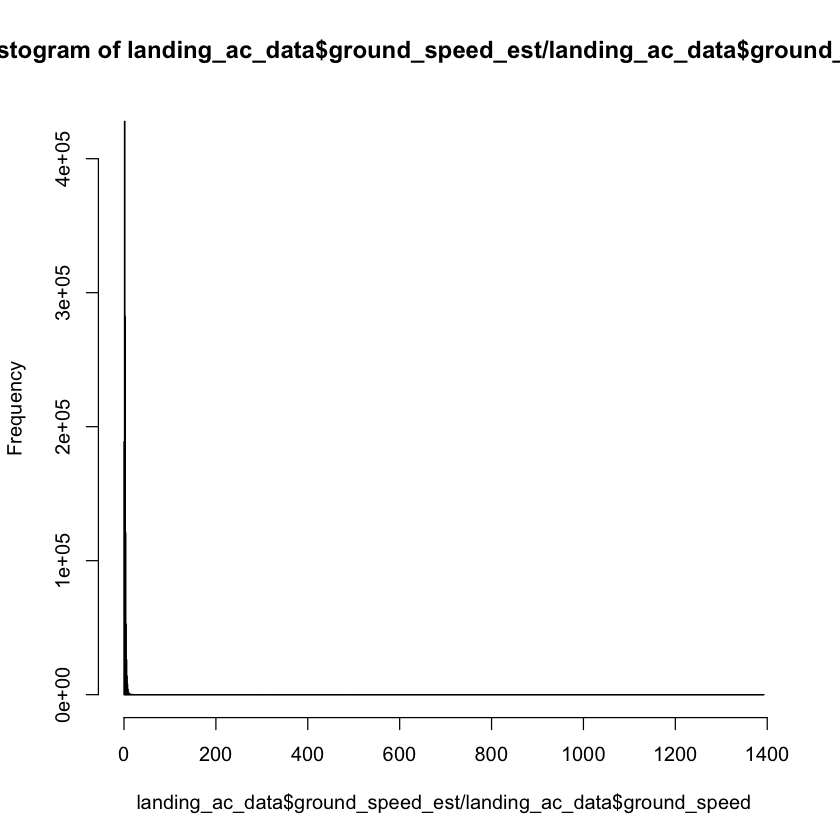

In [13]:
hist(landing_ac_data$ground_speed_est/landing_ac_data$ground_speed, breaks = 1000)

[1] 0.9958288

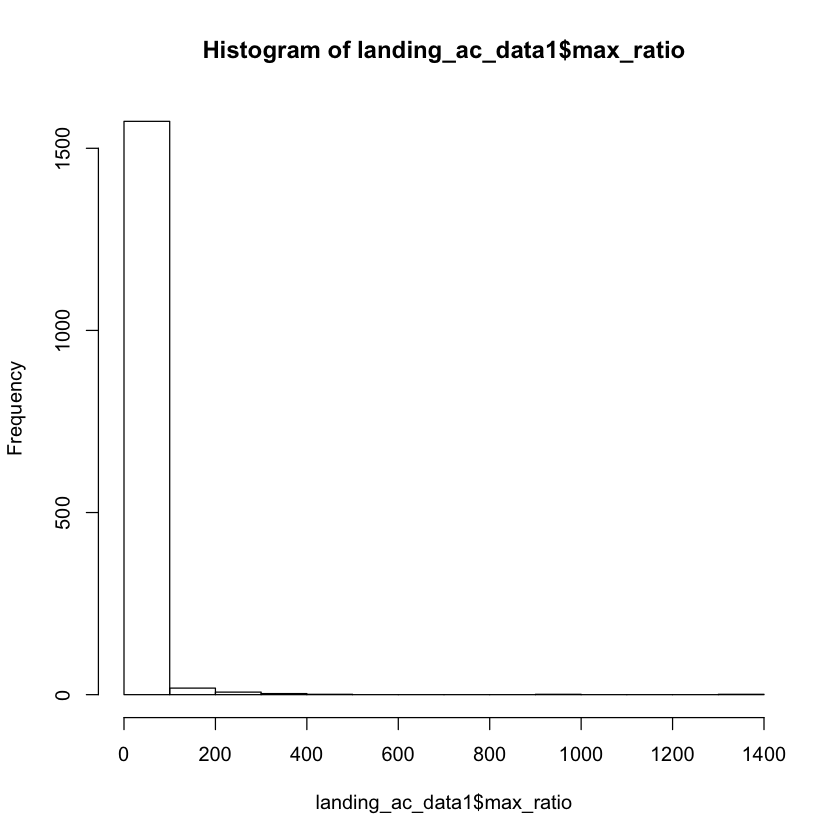

In [14]:
mean(landing_ac_data$ground_speed_est/landing_ac_data$ground_speed <= 20)
landing_ac_data[, "max_ratio" := max(ground_speed_est/ground_speed), by = id]
landing_ac_data1 <- unique(landing_ac_data[, c("id", "max_ratio")])
hist(landing_ac_data1$max_ratio)

In [15]:
nrow(landing_ac_data)
mean(landing_ac_data1$max_ratio <= max_ground_speed_est_ratio)
reqd_ids <- landing_ac_data1$id[landing_ac_data1$max_ratio <= max_ground_speed_est_ratio]
landing_ac_data <- landing_ac_data[sapply(landing_ac_data$id, function(id1) id1 %in% reqd_ids), ]
nrow(landing_ac_data)

[1] 1134203

[1] 0.8751538

[1] 990430

In [16]:
landing_ac_data <- landing_ac_data[landing_ac_data$max_ground_speed_est <= max_ground_speed_est, ]
print(nrow(landing_ac_data))

[1] 990430


In [17]:
landing_ac_data[, "last_alt" := c(NA, altitude[-.N]), by = id]
ht_df <- landing_ac_data[landing_ac_data$altitude != landing_ac_data$last_alt, ]
setorder(ht_df, id, ts)

In [18]:
nrow(ht_df)

[1] 90593

In [19]:
ht_df[, "last_ts" := c(NA, ts[-.N]), by = id]
ht_df$climb_rate <- (ht_df$altitude - ht_df$last_alt)/as.numeric(ht_df$ts - ht_df$last_ts) # ft/s

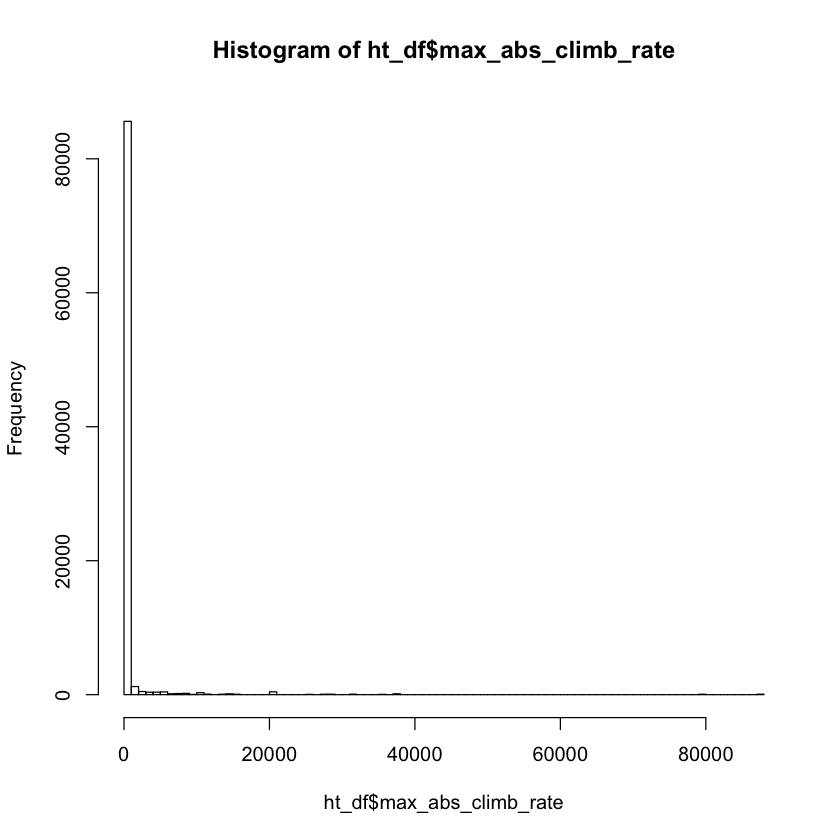

In [20]:
ht_df[, "max_abs_climb_rate" := max(abs(climb_rate), na.rm = T), by = id]
hist(ht_df$max_abs_climb_rate, breaks = 100)

In [21]:
mean(ht_df$max_abs_climb_rate <= max_climb_rate)
clean_landing_id <- unique(ht_df$id[ht_df$max_abs_climb_rate <= max_climb_rate])
length(clean_landing_id)

[1] 0.5402294

[1] 794

In [22]:
landing_ac_data <- landing_ac_data[sapply(landing_ac_data$id, function(id1) id1 %in% clean_landing_id), ]

In [23]:
nrow(landing_ac_data)

[1] 582460

In [24]:
nrow(landing_ac_data)

[1] 582460

In [25]:
landing_ac_data <- filter_m_min_r_rows(landing_ac_data)

In [26]:
length(unique(landing_ac_data$id))

[1] 791

In [27]:
dir.create("clean_landed_id", showWarnings = F)
plot_ac_instances(landing_ac_data, "clean_landed_id")
# landing_ac_data <- get_quadrant(landing_ac_data)

In [28]:
# df1 <- landing_ac_data[landing_ac_data$id == "A41E94_1", ]
# df1[df1$quadrant_change, c("last_lon", "last_lat", "last_ts_diff", "lon", "lat", "quadrant_change", "entered", "landed", "num_id")]

In [29]:
saveRDS(landing_ac_data, "landing_subset_refined.Rds")